<a href="https://colab.research.google.com/github/marinelliluca/gender_coded_sound_ismir2023/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GENDER-CODED SOUND: Analysing the Gendering of Music in Toy Commercials via Multi-Task Learning

Demo from https://github.com/marinelliluca/gender_coded_sound_ismir2023

#### Usage:
- from the menu, select Runtime > Run all
- you can change the input video by providing a youtube link to a toy commercial below

#### Disclaimer
The loaded model supports only two target audiences (masculine or feminine), and is therefore not generalizable to mixed audience commercials.

In [ ]:
!pip install yt-dlp
!pip install pytorch_lightning
!pip install librosa
!pip install torchopenl3
!pip install ffmpeg moviepy
!git clone https://github.com/marinelliluca/gender_coded_sound_ismir2023.git

In [ ]:
%cd gender_coded_sound_ismir2023/

/content/gender_coded_sound_ismir2023


In [ ]:
import numpy as np
import pandas as pd

import torch
from utils import DynamicMultitasker, embedding_dimensions
from compute_embeddings import compute_openl3

import yt_dlp
import moviepy.editor as mp

import glob
import random
import yaml, json
from IPython.display import YouTubeVideo

In [ ]:
which = "openl3_env"
voice = True
targets_list = ["Girls/women", "Boys/men"]

with open("config_save.yaml", "r") as f:
    config = yaml.safe_load(f)

# load quantile normalization parameters
with open(f"quantiles_{which}_voice_{voice}_{len(targets_list)}_cls.json", "r") as f:
    quantiles = json.load(f)


# scales quantization
def value_to_level(value, quantiles):
    # quantiles = [0.33, 0.67]
    if value <= quantiles[0]:
        return "low"
    elif value <= quantiles[1]:
        return "medium"
    else:
        return "high"

In [ ]:
#@title Download YouTube video (insert URL)
youtube_url = "https://www.youtube.com/watch?v=iW7yZlEaPA4" #@param {type:"string"}

yt_id = youtube_url.split("watch?v=")[-1]

video_path = f'./{yt_id}.mp4'

ydl_opts = {
    'outtmpl': video_path,
    "format": "mp4",
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([youtube_url])

[youtube] Extracting URL: https://www.youtube.com/watch?v=iW7yZlEaPA4
[youtube] iW7yZlEaPA4: Downloading webpage
[youtube] iW7yZlEaPA4: Downloading ios player API JSON
[youtube] iW7yZlEaPA4: Downloading android player API JSON
[youtube] iW7yZlEaPA4: Downloading m3u8 information
[info] iW7yZlEaPA4: Downloading 1 format(s): 22
[download] Destination: ./iW7yZlEaPA4.mp4
[download] 100% of    3.04MiB in 00:00:01 at 1.83MiB/s   


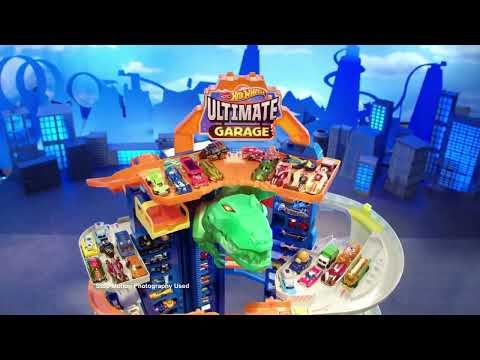

In [ ]:
YouTubeVideo(yt_id)

#### Extract audio

In [ ]:
video = mp.VideoFileClip(video_path)

# trim 5 last seconds (which usually contain the audio logo of the retailer)
# video = video.subclip(0, video.duration - 5)

video.audio.write_audiofile(video_path.replace("mp4","mp3"))

MoviePy - Writing audio in ./iW7yZlEaPA4.mp3


MoviePy - Done.


### load model

In [ ]:
# set the parameters for the model
config["cls_dict"]["target"] = targets_list # add target list to config
params = {
    "input_dim": embedding_dimensions["music"][which],
    "n_emo": 6,
    "n_mid": 12,
    "cls_dict": config["cls_dict"],
    "filmed": False,
}

# Load model:
model = DynamicMultitasker(**params)
model.load_state_dict(
    torch.load(
    f"models/{which}_{voice}_voice_{len(targets_list)}_cls.pt"
    )
)
model.eval()

DynamicMultitasker(
  (hidden): Linear(in_features=512, out_features=128, bias=True)
  (hidden_mid): Linear(in_features=128, out_features=128, bias=True)
  (out_mid): Linear(in_features=128, out_features=12, bias=True)
  (hidden_emo): Linear(in_features=128, out_features=128, bias=True)
  (out_emo): Linear(in_features=128, out_features=6, bias=True)
  (bn_cls): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden_cls): Linear(in_features=128, out_features=128, bias=True)
  (out_cls): ModuleDict(
    (voice_gender): Linear(in_features=128, out_features=4, bias=True)
    (voice_exagg): Linear(in_features=128, out_features=4, bias=True)
    (voice_type): Linear(in_features=128, out_features=4, bias=True)
    (voice_age): Linear(in_features=128, out_features=4, bias=True)
    (target): Linear(in_features=128, out_features=2, bias=True)
  )
)

## Compute OpenL3 (env) embeddings

In [ ]:
embedding = compute_openl3(video_path.replace("mp4","mp3")).mean(axis=0)

Downloading: "https://github.com/torchopenl3/torchopenl3-models/raw/master/torchopenl3_mel128_env_512.pth.tar" to /root/.cache/torch/hub/checkpoints/torchopenl3_mel128_env_512.pth.tar
100%|██████████| 34.4M/34.4M [00:00<00:00, 142MB/s]


## Predict

In [ ]:
emotions = ['Happy', 'Beauty', 'Calm', 'Energizing', 'Angry', 'Triumphant']

mid_levels = [
       'Electric/Acoustic', 'Distorted/Clear', 'Many/Few Instruments',
       'Loud/Soft', 'Heavy/Light', 'High/Low pitch', 'Punchy/Smooth',
       'Harmonious/Disharmonious', 'Clear melody/No melody',
       'Complex/Simple rhythm', 'Dense/Sparse', 'Strong beat/Weak beat'
]

In [ ]:
with torch.no_grad():
    y_mid_pred, y_emo_pred, y_cls_pred = model(
        torch.from_numpy(embedding[np.newaxis,:]).float()
    )

y_emo_pred = y_emo_pred.numpy()
y_mid_pred = y_mid_pred.numpy()
y_cls_pred = {k: int(torch.argmax(y_cls_pred[k], dim=1).numpy()) for k in config["cls_dict"]}

cls_dict = config["cls_dict"]
cls_dict["target"] = targets_list

print("Predicted target:", cls_dict["target"][y_cls_pred["target"]])

for k in cls_dict:
    if k != "target":
        print(f"{k}: {cls_dict[k][y_cls_pred[k]]}")

# print level for each emotion
for i in range(y_emo_pred.shape[1]):
    k = emotions[i]
    print(f"{k}: {value_to_level(y_emo_pred[:,i], quantiles[k])}")

# print level for each mid-level feature
for i in range(y_mid_pred.shape[1]):
    k = mid_levels[i]
    print(f"{k}: {value_to_level(y_mid_pred[:,i], quantiles[k])}")

Predicted target: Boys/men
voice_gender: Masculine
voice_exagg: Yes a masculine voice is gender exaggerated
voice_type: Spoken
voice_age: Adults (including young adults)
Happy: low
Beauty: low
Calm: low
Energizing: high
Angry: high
Triumphant: high
Electric/Acoustic: low
Distorted/Clear: low
Many/Few Instruments: medium
Loud/Soft: medium
Heavy/Light: low
High/Low pitch: high
Punchy/Smooth: medium
Harmonious/Disharmonious: high
Clear melody/No melody: high
Complex/Simple rhythm: medium
Dense/Sparse: low
Strong beat/Weak beat: high
